# Milestone 4 - CS109B Project Group 29
**"Predicting Movie Genres"**<br>
**CS109B (Spring 2017) Final Project Group 29**<br>
Calvin J Chiew, Tim Hagmann, Ji Hua<br>
TF: Kela Roberts<br>

## Deliverables

- Complete description of the deep network you trained from scratch, including parameter settings, performance, features learned, etc.
- Complete description of the pre-trained network that you fine tuned, including parameter settings, performance, features learned, etc.
- Discussion of the results, how much improvement you gained with fine tuning, etc.
- Discussion of at least one additional exploratory idea you pursued

## Import Libraries

In [3]:
import tensorflow as tf
import numpy as np
import os
import sys
import random
from PIL import Image
from PIL import ImageEnhance
import PIL.ImageOps
from six.moves import cPickle as pickle
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Conv3D, MaxPooling3D
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,Adam
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau

from keras import backend as K
import pandas as pd

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

import numpy as np
from time import time, sleep

Using TensorFlow backend.


## Overview

In this milestone, we will use movie posters extracted from TMDb to develop deep learning networks for the task of multi-label movie genre prediction. We will train one small convolutional neural network (CNN) from scratch using Keras with TensorFlow backend, as well as fine-tune another existing pre-trained network, and compare their results. To speed up computation, the models were run on the "p2.xlarge" GPU compute instances on Amazon Web Services (AWS)'s Elastic Compute Cloud (EC2).

---

## Data Preparation

Previously, we have downloaded posters for about 69,000 movies from TMDb in w154 resolution (154x231 pixels) and `.jpg` format. Here, we use the Python Imaging Library (PIL) to pre-process these `.jpg` images into matrices of pixel values. All posters are resized to 154x154 pixels and then their RGB channel values are extracted into matrices of dimensions 154x154x3.

We also stored the corresponding genre labels (there are a total of 19 different genres) in a separate pickle file. To limit output file sizes, we processed the posters in batches of 1000 posters (total 69 batches).

In [8]:
genres = pd.read_csv('../data/clean_data/genres_70k_new.txt')
genres = genres.drop('TVMovie', 1)

In [9]:
tmdb_index_dict={}
for i in range(genres.shape[0]):
    tmdb_index_dict[genres.iloc[i,0]]=i

In [2]:
DATA_PATH = "/home/ubuntu/new_data/data/poster_154/"
SAVE_PATH="/home/ubuntu/new_data/data/poster_154_resize/"
VALIDATION_PERCENT = .2
TEST_PERCENT = .2
IMAGE_WIDTH = 154
IMAGE_HEIGHT=154
IMAGE_SIZE=154
NUM_CHANNELS = 3 #RGB channels
PIXEL_DEPTH = 255.0
NUM_GENRES = 19
NUM_ROWS=1000
PARTITION_TEST = False

In [11]:
def to_rgb(im):
    w, h = im.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, :] = im[:, :, np.newaxis]
    return ret
def read_image_from_file(file_path):
    img = Image.open(file_path).convert('RGB')
    img = img.resize((IMAGE_WIDTH,IMAGE_HEIGHT), Image.ANTIALIAS) #downsample image
    pixel_values = np.array(img.getdata())
    return np.reshape(pixel_values, [IMAGE_WIDTH,IMAGE_HEIGHT, NUM_CHANNELS])
def make_dataset_arrays(num_rows=NUM_ROWS):
    data = np.ndarray((num_rows, IMAGE_WIDTH,IMAGE_HEIGHT, NUM_CHANNELS), dtype=np.float32)
    labels = np.ndarray((num_rows, NUM_GENRES), dtype=np.int32)
    return data, labels
def scale_pixel_values(dataset):
    return (dataset - PIXEL_DEPTH / 2.0) / PIXEL_DEPTH


In [12]:
train_data, train_labels = make_dataset_arrays()
num_train = 0
num_group=0
startTime = time()
for filename in os.listdir(DATA_PATH):
    if filename.endswith(".jpg"): 
        
        if num_train<NUM_ROWS:
            image=read_image_from_file(DATA_PATH+filename)
            tmdb_id=int(filename.split(".")[0])
            index=tmdb_index_dict[tmdb_id]
            labels=genres.iloc[index,1:]
            train_data[num_train]=image
            train_labels[num_train]=labels
            num_train+=1
        else:
            pickle_file = SAVE_PATH+str(num_group)+'_data.pickle'
            save = {
                'train_data': train_data,
                'train_labels': train_labels,
            }
            pickle.dump(save,open(pickle_file, 'wb'))
            train_data = scale_pixel_values(train_data)
            train_data, train_labels = make_dataset_arrays()
            num_train = 0
            num_group+=1
            endTime = time()-startTime
            startTime = time()
            print(num_group,endTime)
    else:
        continue


1 21.86195468902588
2 21.592482328414917
3 21.36932945251465
4 21.11618733406067
5 20.961125135421753
6 21.30031991004944
7 21.15892744064331
8 21.05839729309082
9 21.06325936317444
10 21.056663751602173
11 20.981106281280518
12 21.149512767791748
13 21.169286251068115
14 21.075929403305054
15 21.12622094154358
16 21.012732982635498
17 21.153006553649902
18 21.161320209503174
19 21.139780282974243
20 21.122400283813477
21 21.111783742904663
22 21.0002658367157
23 21.164196252822876
24 21.182477474212646
25 21.081981420516968
26 21.11357021331787
27 21.083905696868896
28 20.975043535232544
29 21.17864990234375
30 21.14852809906006
31 21.080682277679443
32 21.091574668884277
33 21.07645893096924
34 21.05786681175232
35 21.16805601119995
36 21.15083122253418
37 21.122097492218018
38 21.10979700088501
39 21.17454218864441
40 21.294508695602417
41 21.17664122581482
42 21.119178771972656
43 21.150924682617188
44 21.11747980117798
45 21.04141139984131
46 21.195682048797607
47 21.2145152091979

---

## Training a Network from Scratch

In view of computation time and to focus on the correctness of our code (for now), we only used 10,000 posters (10 batches) for training and 5,000 posters (5 batches) for testing, even though we had data for 69,000 posters (69 batches). As the posters were grouped into batches in no particular pattern, this represents a random sampling. We intend to increase the number of training and testing samples for our final project milestone, and perhaps cherry pick posters (see discussion below).

### Network Architecture & Parameter Settings

The architecure of our CNN is as follows:
- [154x154x3] INPUT: 154x154 RGB image
- [150x150x32] CONV1: 32 5x5 filters at stride 1, pad 0
- [148x148x32] CONV2: 32 3x3 filters at stride 1, pad 0
- [74x74x32] MAXPOOL1: 2x2 filters at stride 2
- [72x72x32] CONV3: 32 3x3 filters at stride 1, pad 0
- [70x70x32] CONV4: 32 3x3 filters at stride 1, pad 0
- [35x35x32] MAXPOOL2: 2x2 filters at stride 2
- FC1: 64 neurons
- FC2: 19 neurons (output classes)

Other design choices made are as follows:
- Activation function: Rectified linear unit (ReLU) for hidden layers, sigmoid for output layer
- Optimization method: Adam
- Loss function: Binary cross-entropy
- Dropout: 0.25 on hidden layer, 0.5 on fully-connected layer
- Regularization: None (for now, KIV to add L2)
- Weight initialization: Glorot uniform
- Data pre-processing: Centering and normalization
- Data augmentation: Re-scaling, rotation, width shift, height shift, horizontal flip

The main parameters of our network are as follows:
- Learning rate: 0.1, reduced by factor of 0.2 when validation loss plateaus for 1 epoch, until minimum of 0.001
- Batch size: 500
- Number of epochs: 20 (fixed for now, KIV to add early stopping when validation loss plateaus for X number of epochs)

In [1]:
DATA_PATH = "/home/ubuntu/new_data/data/poster_154/"
SAVE_PATH="/home/ubuntu/new_data/data/poster_154_resize/"
VALIDATION_PERCENT = .2
TEST_PERCENT = .2
IMAGE_WIDTH = 154
IMAGE_HEIGHT=154
IMAGE_SIZE=154
NUM_CHANNELS = 3 #RGB channels
PIXEL_DEPTH = 255.0
NUM_GENRES = 19
NUM_ROWS=1000
input_shape = ( IMAGE_WIDTH,IMAGE_HEIGHT, 3)
# smaller batch size means noisier gradient, but more updates per epoch
batch_size = 500
# this is fixed, we have 10 digits in our data set
num_classes = NUM_GENRES
# number of iterations over the complete training data
epochs = 20
##sample batch
num_batch=15

In [28]:
input_shape = ( IMAGE_WIDTH,IMAGE_HEIGHT, 3)
#sample_index=random.sample(range(69), num_batch)
sample_index=np.arange(25)
train_index=sample_index[:10]
test_index=sample_index[10:]
num_test=len(test_index)*NUM_ROWS
num_train=len(train_index)*NUM_ROWS
train_X=np.zeros((num_train,IMAGE_WIDTH,IMAGE_HEIGHT, 3))
train_Y=np.zeros((num_train,NUM_GENRES))
test_X=np.zeros((num_test,IMAGE_WIDTH,IMAGE_HEIGHT, 3))
test_Y=np.zeros((num_test,NUM_GENRES))

In [29]:
for i in range(len(train_index)):
    file_name=str(train_index[i])+"_data.pickle"
    pickle_file=SAVE_PATH+file_name
    with open(pickle_file, 'rb') as f:
        save = pickle.load(f)
        train_X[i*NUM_ROWS:(i+1)*NUM_ROWS] = save['train_data']
        train_Y[i*NUM_ROWS:(i+1)*NUM_ROWS] = save['train_labels']

In [30]:
for i in range(len(test_index)):
    file_name=str(test_index[i])+"_data.pickle"
    pickle_file=SAVE_PATH+file_name
    with open(pickle_file, 'rb') as f:
        save = pickle.load(f)
        test_X[i*NUM_ROWS:(i+1)*NUM_ROWS] = save['train_data']
        test_Y[i*NUM_ROWS:(i+1)*NUM_ROWS] = save['train_labels']

In [6]:
print(test_X.shape)

(5000, 154, 154, 3)


In [13]:
datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [34]:
model = Sequential()
# input: 100x100 images with 3 channels -> (100, 100, 3) tensors.
# this applies 32 convolution filters of size 3x3 each.
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_GENRES,activation='sigmoid'))

# prints out a summary of the model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 150, 150, 32)      2432      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 148, 148, 32)      9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 70, 70, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 35, 35, 32)        0         
__________

In [41]:
adam=Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#sgd = SGD(lr=0.1, momentum=0.9)
#early_stopping = EarlyStopping(monitor='val_loss',patience=2)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
              patience=1, min_lr=0.001)
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [42]:
history = model.fit_generator(datagen.flow(train_X, train_Y,batch_size=batch_size), 
                    steps_per_epoch=len(train_X) / batch_size,
                    epochs=epochs,
                    validation_data=datagen.flow(test_X, test_Y),
                    validation_steps=len(test_X) / batch_size,
                    callbacks=[reduce_lr])

Epoch 1/20
20/20 [==============================] - 54s - loss: 5.0437 - acc: 0.6840 - val_loss: 5.2339 - val_acc: 0.6720

### Network Performance

Our network achieved a test accuracy of 38%. We think its poor performance is due to insufficient optimization of our model architecture and settings, and we hope to improve on this with more time for parameter tuning.

In [24]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 25.4279073944
Test accuracy: 0.3774


Here, we visualize the accuracy over the training process. The accuracy appears to have plateaued after the 2nd epoch.

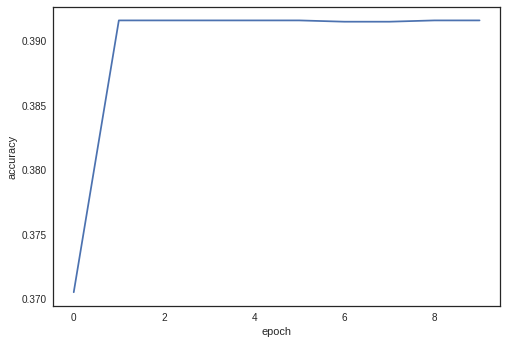

In [37]:
# here is a visualization of the training process
# typically we gain a lot in the beginning and then
# training slows down
plt.plot(history.history['acc'])
plt.xlabel("epoch")
plt.ylabel("accuracy")

In [ ]:
sgd = SGD(lr=0.1, momentum=0.9)
#optimizer=Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
history = model.fit(train_X, train_Y,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(test_X, test_Y))

### Features Learnt

Visualize filters

---

## Fine-tuning a Pre-trained Network

(Tim to fill this section)

---

## Discussion

Our networks had several weaknesses which we plan to address as follows:
- Further tuning of the network's architecture and parameters to improve performance, such as increasing the number of convolutional filters and number of neurons in the dense layer, decreasing the learning rate and batch size, etc.
- Increase the number of training and testing samples, and perhaps cherry pick posters we want to sample, which are "representative" of their genres
- Generate Tensorflow log files for monitoring and visualization on Tensorboard (eg. loss curve)
- Add regularization and early stopping
- KIV insert BatchNorm layers
- Use separate samples for validation and testing instead of the same set

---

## Next Steps

Moving forward, we will work on improving our models as discussed above, and perhaps combine the predictions of our deep networks with earlier classifiers (eg. random forest) trained on movie metadata. We will present our final results in a screencast and report.